# Rail Track Anomaly Detection Using Two-Model Solution
Author: Lwam Teklay

This notebook presents a comprehensive solution for detecting anomalies on rail tracks employing a two-stage model architecture. The approach involves leveraging a U-Net model for precise segmentation of regions of interest, followed by a classification model to identify anomalies within these segmented areas.

The dataset utilized in this project comprises images of rail tracks along with their corresponding masks, facilitating supervised learning for model training and evaluation. Through the combined utilization of advanced deep learning techniques, this solution aims to enhance rail track maintenance and safety protocols by enabling automated anomaly detection.

#Classification Model for Rail Track Anomaly Detection

## Step 1: Importing Libraries
In this step, we import the necessary libraries and modules to facilitate the implementation of our classification model for rail track anomaly detection.

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, f1_score
import random
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau

from PIL import Image

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, Reshape, MaxPool2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping


## Step 2: Preparing the Dataset


In [ ]:
#we mount Google Drive to access the necessary files.
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##Dataset Generation Setup:
The following ImageDataGenerators are responsible for loading the images from their respective directories, applying necessary preprocessing and augmentations (for training data), and preparing them in batches to be fed into the neural network during the training, validation, and testing phases.

In [ ]:
# ImageDataGenerator for Training Data (train_generator)
train_generator = ImageDataGenerator(rescale=1./255,
                                     shear_range=0.2,
                                      zoom_range=0.3,
                                      width_shift_range=0.3,
                                      height_shift_range=0.2,
                                      brightness_range=[0.4,1.5],
                                      horizontal_flip=True,
                                      vertical_flip =True
                                     )
val_generator = ImageDataGenerator(rescale=1./255)

test_generator = ImageDataGenerator(rescale=1./255)

#Loading and Preprocessing the Data
train_generator = train_generator.flow_from_directory(
    directory="/content/drive/My Drive/RailTrackAnomaly detection/dataset2/train",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='categorical',
    batch_size = 32,
    subset='training') # set as training data

validation_generator = val_generator.flow_from_directory(
    directory="/content/drive/My Drive/RailTrackAnomaly detection/dataset2/validation",
    target_size=(224,224),
    color_mode="rgb",
    class_mode='categorical',
    batch_size = 32,
    shuffle=False)

test_generator = test_generator.flow_from_directory(
    directory="/content/drive/My Drive/RailTrackAnomaly detection/dataset2/test",
    target_size=(224,224),
    color_mode="rgb",
    class_mode='categorical',
    batch_size = 32,
    shuffle = False)

Found 504 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 72 images belonging to 2 classes.


## Step 3: Visualizing Data

The following function visualizes sample images from the dataset.

In [ ]:
def visualize_data(path):

    src_path = path
    sub_class = os.listdir(src_path)

    fig = plt.figure(figsize=(20,10))

    count=1
    for label in range(len(sub_class)):
        path = os.path.join(src_path,sub_class[label])
        img = os.listdir(path)


        for i in img[:4]:
            plt.subplot(2,4,count)
            image = Image.open(path+"/"+i)
            image = image.resize((300,300))
            plt.imshow(image)
            plt.title(sub_class[label])
            count+=1

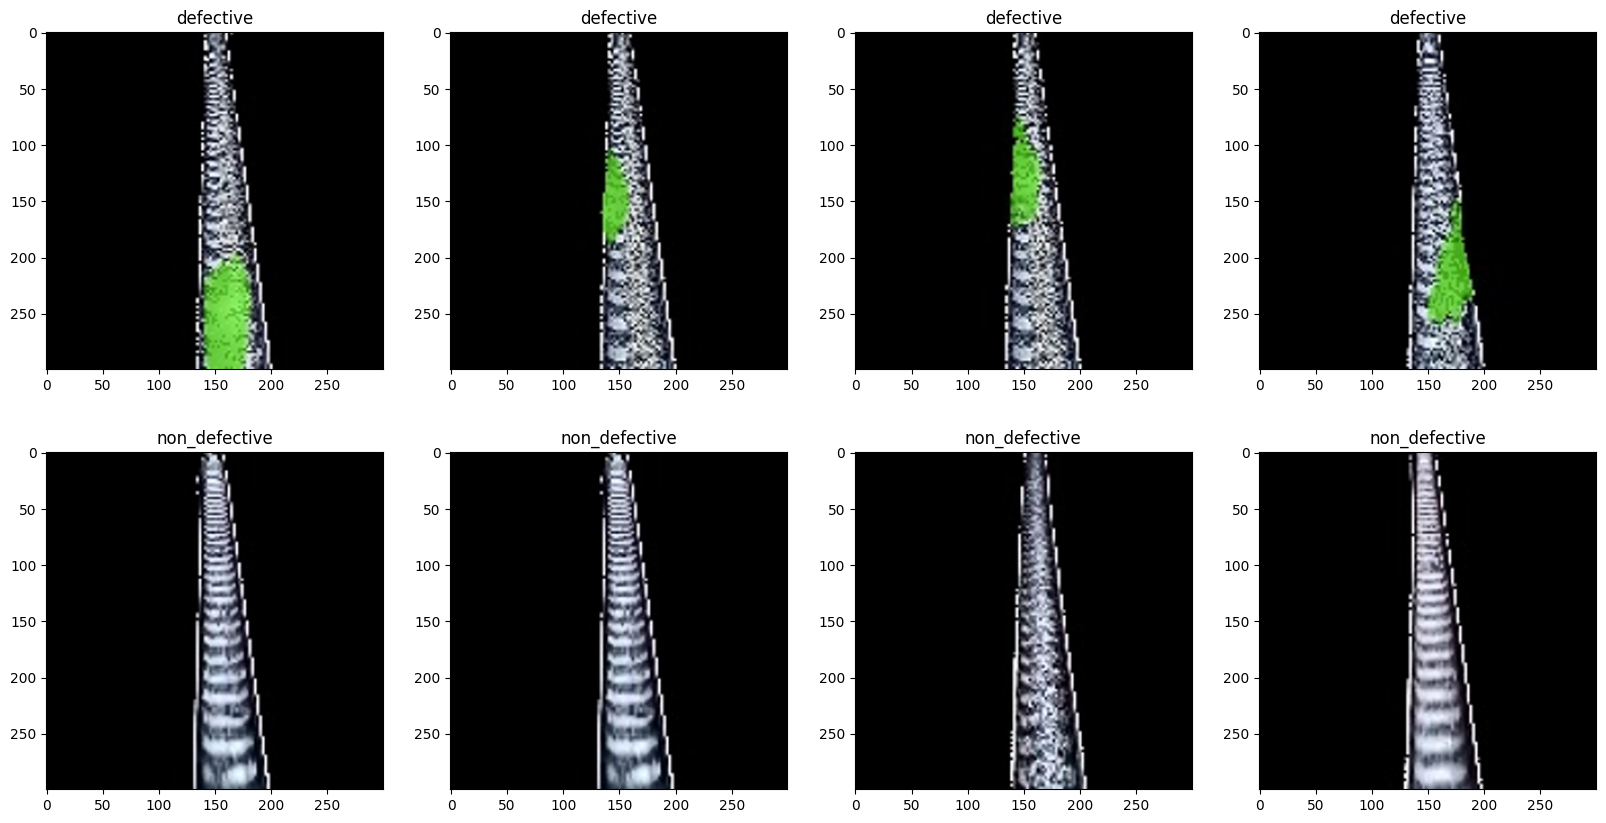

In [ ]:
visualize_data("/content/drive/My Drive/RailTrackAnomaly detection/dataset2/test")

## Step 4: Model Configuration and Training
#### Model Configuration:

In this step, we configure a convolutional neural network (CNN) for a classification task. We utilize a pre-trained VGG16 model as a feature extractor and add custom layers on top to tailor the model to the specific task.

The use of a pre-trained model like VGG16 leverages the power of a large, already trained neural network, which can be very effective in improving performance on a smaller dataset or a specific task like anomaly detection.

In [ ]:
#Import and Initialize VGG16
from tensorflow.keras.applications.vgg16 import VGG16

model_train = VGG16(input_shape=(224,224,3) , weights='imagenet', include_top=False)

#Freezing the Layers of VGG16
for layer in model_train.layers:
    layer.trainable = False

#Adding Custom Layers
x = Reshape((7*7,512))(model_train.output)
x = Flatten()(x)
x = Dense(128)(x)
x = Dense(64)(x)
prediction = Dense(2, activation='softmax')(x)

#Creating the Final Model
model = Model(inputs=model_train.input, outputs=prediction)


58889256/58889256 [==============================] - 0s 0us/step


#### Model Compilation:
We compile the model by specifying the optimizer, loss function, and evaluation metrics.

In [ ]:
model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

#### Model Training:
We train the model by utilizing training and validation data generators using the following function, which sets up a comprehensive training process for the model, including strategies like learning rate reduction on plateaus, early stoppoing, and model checkpoints.

In [ ]:

def train_model(model, train_generator, validation_generator, epochs,name):
    path_cp = name + '_vowels_weights.hdf5'
    rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 4, verbose = 1,
                                min_delta = 1e-4, min_lr = 1e-4, mode = 'min', cooldown=1)

    ckp = ModelCheckpoint(path_cp,monitor = 'val_loss',
                      verbose = 1, save_best_only = True, mode = 'min')

    es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 6,mode = 'min', restore_best_weights = True, verbose = 1)


# Fitting the model
    history = model.fit(train_generator,
                          epochs = epochs,
                          validation_data = validation_generator,
                          verbose = 1,
                          callbacks = [rlr,es,ckp])
    return history


In [ ]:
train_history = train_model(model, train_generator,validation_generator, epochs = 50,name="vgg16")

#### Model Evaluation:
We evaluate the trained model on the training, validation, and test datasets, respectively. The 'evaluate' function returns the loss value and accuracy metrics for the evaluation.

In [ ]:
#training data
model.evaluate(train_generator)

16/16 [==============================] - 9s 549ms/step - loss: 0.1273 - accuracy: 0.9583


[0.1273045688867569, 0.9583333134651184]

In [ ]:
#validation data
model.evaluate(validation_generator)

5/5 [==============================] - 1s 116ms/step - loss: 0.0081 - accuracy: 1.0000


[0.008115525357425213, 1.0]

In [ ]:
#test data
model.evaluate(test_generator)

3/3 [==============================] - 10s 5s/step - loss: 0.0116 - accuracy: 1.0000


[0.01160826813429594, 1.0]

#### Saving the Model:
Finally, we save the trained model to a file. The .h5 file format includes the model's architecture, weights, training configuration, and optimizer state, allowing us to resume training where we left off.

In [ ]:
# save the trained model
model.save('my_model.keras').
  tf.keras.models.save_model(model,"railTrack_modelFriday.h5")

#save training history
import pickle
with open('railTrack_modelFriday_history.pkl', 'wb') as file_pi:
    pickle.dump(train_history.history, file_pi)

#loading the history
with open('railTrack_modelFriday_history.pkl', "rb") as file_pi:
    history = pickle.load(file_pi)

## Step 5: Model Evaluation and Visualization

#### Visualizing Training History:

We visualize the training history by plotting the model's accuracy and loss metrics over epochs.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


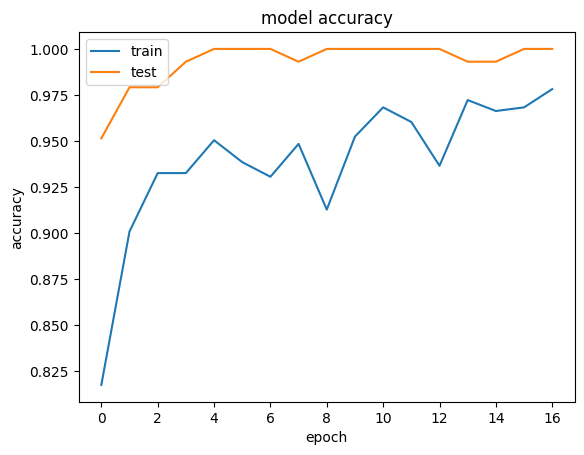

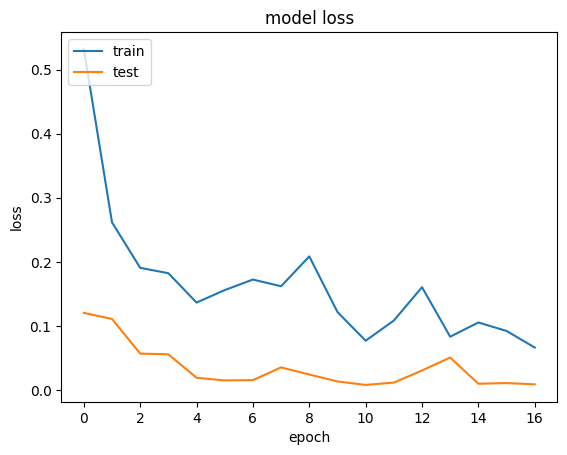

In [ ]:
# list all data in history
print(history.keys())

# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model Metric Visualization:
We visualize metrics such as classification reports and confusion matrixes for better understanding model performance.

In [ ]:
#Predicted label
def metric_visualization(generator):

    y_pred = model.predict(generator)
    y_pred_label = np.argmax(y_pred,axis=1)

    #true labels
    y_test = generator.classes

    class_report =  classification_report(y_test,y_pred_label,target_names=['fault','no fault'],output_dict=True)
    sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, annot=True,cmap='inferno')

    conf_matrix = confusion_matrix(y_test, y_pred_label)
    plt.figure(figsize=(10,6))
    fx=sns.heatmap(confusion_matrix(y_test,y_pred_label), annot=True, fmt=".2f",cmap="inferno")
    fx.set_title('Confusion Matrix \n')
    fx.set_xlabel('\n Predicted Values\n')
    fx.set_ylabel('Actual Values\n')
    fx.xaxis.set_ticklabels(['fault','no fault'])
    fx.yaxis.set_ticklabels(['fault','no fault'])
    plt.show()

5/5 [==============================] - 1s 129ms/step


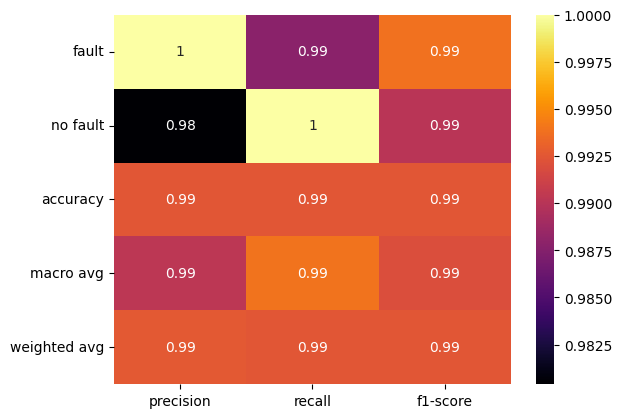

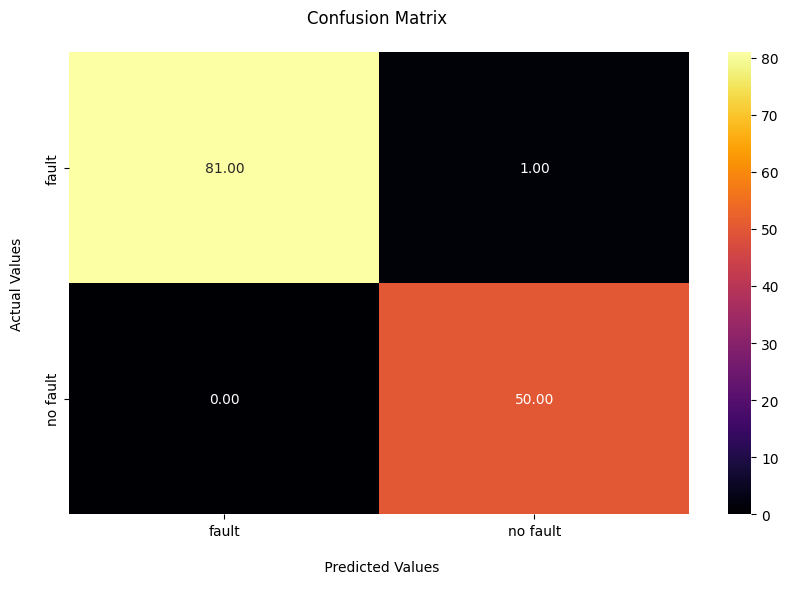

In [ ]:
metric_visualization(validation_generator)

3/3 [==============================] - 1s 142ms/step


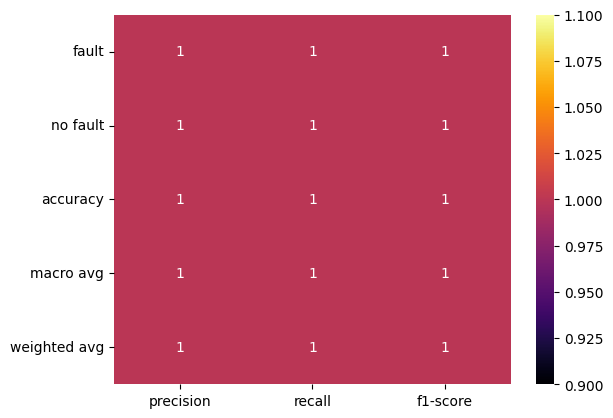

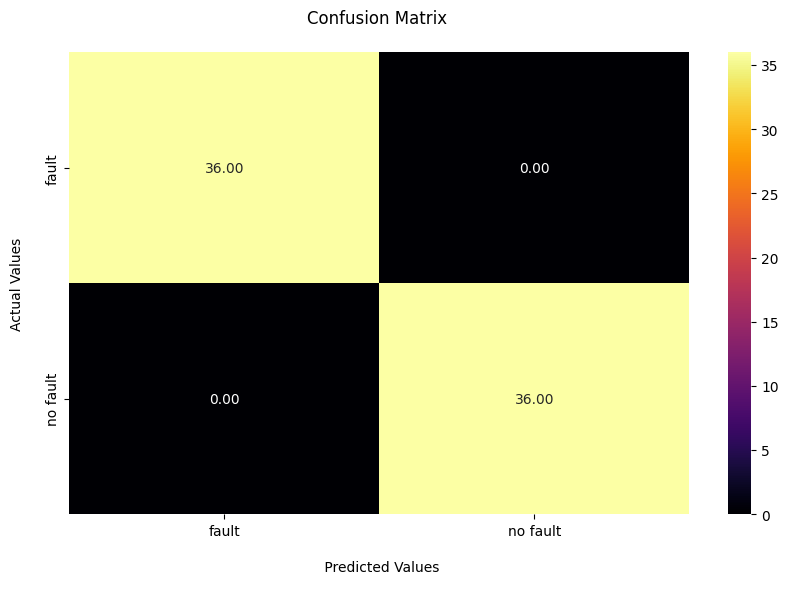

In [ ]:
metric_visualization(test_generator)

#### Model Prediction Visualization:
We visualize model predictions on sample images from the dataset.

1/1 [==============================] - 0s 280ms/step


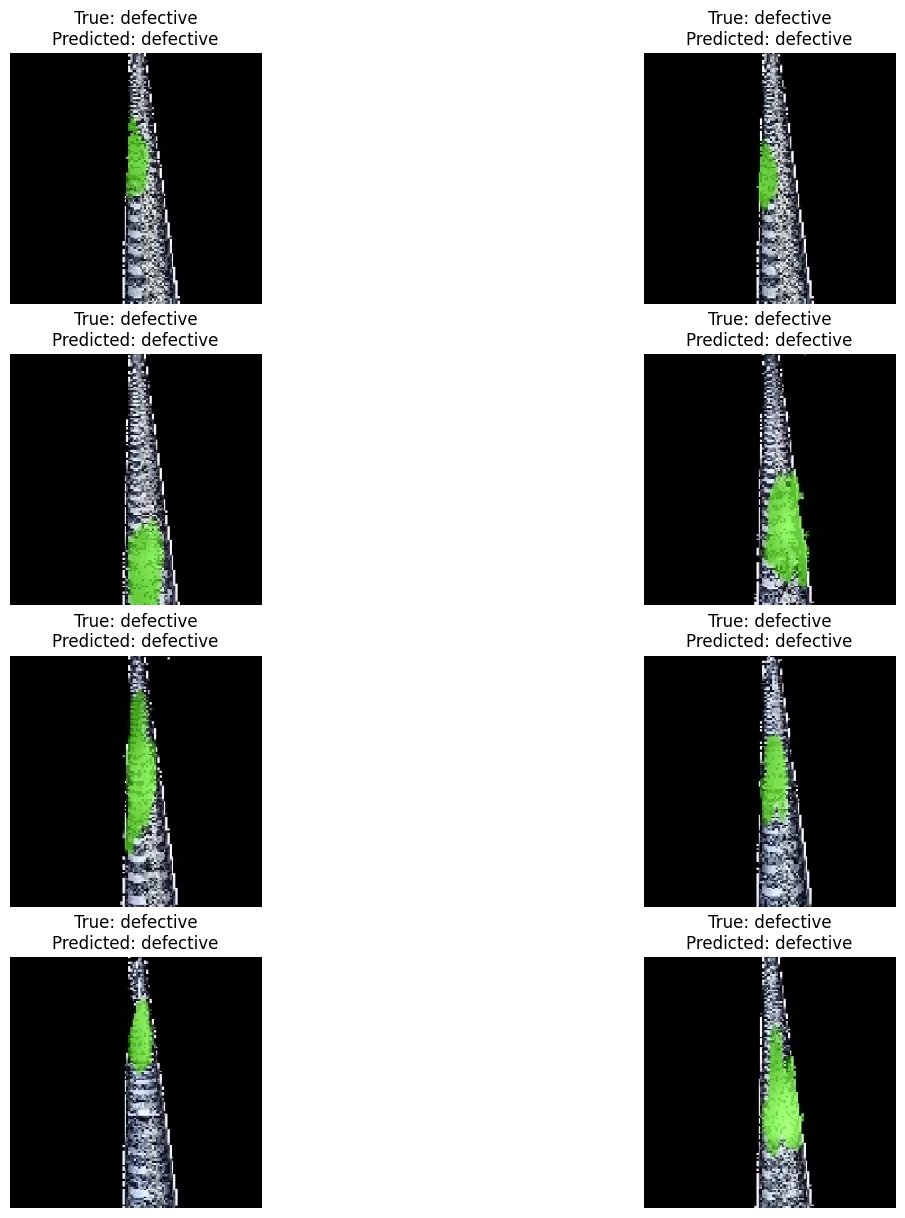

In [ ]:
def plot_images_with_predictions(model, generator, num_images=10):
    # Get a batch of test data
    for images, labels in generator:
        break

    predictions = model.predict(images)
    class_indices = np.argmax(predictions, axis=1)

    # Inverse transform from one hot encoding if necessary
    if generator.class_mode == 'categorical':
        true_labels = np.argmax(labels, axis=1)
    else:
        true_labels = labels

    # Mapping of classes
    labels_map = {v: k for k, v in generator.class_indices.items()}

    # Plot images
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(num_images//2, 2, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {labels_map[true_labels[i]]}\nPredicted: {labels_map[class_indices[i]]}")
        plt.axis("off")
    plt.show()

# Call the function with our model and test_generator
plot_images_with_predictions(model, test_generator, num_images=8)


# Step 6: Conclusion

In this notebook, we detailed the implementation of our classification model for rail track anomaly detection, the second crucial component of our two-stage anomaly detection solution.

Our journey began with the preparation of the dataset, where we employed ImageDataGenerators to load and preprocess images, ensuring their suitability for model training. Through augmentation techniques, we augmented the training data, enhancing  the model's ability to generalize to unseen scenarios.

Central to our approach was the configuration of a convolutional neural network (CNN), utilizing a pre-trained VGG16 model as a feature extractor. Custom layers were added to tailor the model to our specific anomaly detection task, maximizing its efficiency.

Following model compilation and training, we evaluated its performance on training, validation, and test datasets, leveraging comprehensive evaluation metrics to assess accuracy and loss. By visualizing training history, classification reports, and confusion matrices, we gained insights into the model's performance and areas for improvement.

Through model evaluation and visualization, we demonstrated the efficiency of our classification model in identifying anomalies within segmented regions, complementing the segmentation model's output effectively.





In conclusion, one of the key challenges we encountered was the availability of defective dataset samples. Given the time constraints and resource limitations, it was impractical to manually curate a comprehensive dataset encompassing various types and severities of anomalies. To address this challenge, we employed a pragmatic approach by leveraging paint to prepare defect datasets, representing anomalies in our context.

This decision was driven by the need for simplicity and efficiency, ensuring that our model could learn effectively from the limited dataset available. Despite the modest size of the dataset, our classification model demonstrated promising performance, underscoring the viability of our proof-of-concept approach.

It is important to emphasize that this project serves as a proof of concept, showcasing the feasibility of automated rail track anomaly detection. With enough time and resources, we envision scaling up our approach to accommodate larger and more diverse datasets, enabling the identification of specific anomaly types and severity levels.

By highlighting the scalability and potential of our proof-of-concept solution, we aim to convey its significance and value proposition to our stakeholders, including RideOnTrack. Through continued refinement and investment, we believe our approach holds immense promise in revolutionizing rail track maintenance and safety protocols through automated anomaly detection.